In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

raw_data = pd.read_csv('../data/2021-SxS-Data-and-Data-Info/partial_cleaned_2021.csv')
raw_data.drop(columns='Unnamed: 0', inplace= True)
raw_data.head()

,state,division,region,gender,age_group,ethnicity,ed_lvl,marital_stat,lvng_arr,marital_stat_v2,...,10k_expense,10k_gift,expect_inheritance,num_cred_cards,health_ins,skipped_med,fin_conf_lvl,math_conf_lvl,knowledge_conf_lvl,fin_ed
0,South Carolina,South Atlantic,South,female,25-34,white,Bachelors,married,2,married,...,1,1,1,2,1,2,7,6,6,2
1,Ohio,East North Central,Midwest,female,25-34,white,Bachelors,divorced,1,single,...,2,2,2,7,1,2,1,1,2,2
2,Arizona,Mountain,West,male,65+,white,Bachelors,divorced,1,single,...,2,2,2,3,1,2,7,7,6,2
3,Arizona,Mountain,West,female,45-54,non-white,HS Grad,married,2,married,...,2,2,2,2,1,2,7,6,5,3
4,Ohio,East North Central,Midwest,female,45-54,white,GED,divorced,1,single,...,2,2,98,7,1,2,6,6,5,3


In [7]:
#Military Only (current or previous)
mil_only_df = raw_data[(raw_data['mil_stat'] == 'current') | (raw_data['mil_stat'] == 'previous')]


In [8]:
combined_df = raw_data[['state','region','math_conf_lvl','fin_sat_lvl','fin_conf_lvl', 'ed_lvl', 'caregiver_ed_lvl', 'hh_ann_inc']]
# Replace all 99 &98 answers with none in columns & drop them since it skews mean
combined_df.loc[combined_df['math_conf_lvl'] == 99, 'math_conf_lvl'] = None
combined_df.loc[combined_df['fin_sat_lvl'] == 99, 'fin_sat_lvl'] = None
combined_df.loc[combined_df['fin_conf_lvl'] == 99, 'fin_conf_lvl'] = None
combined_df.loc[combined_df['math_conf_lvl'] == 98, 'math_conf_lvl'] = None
combined_df.loc[combined_df['fin_sat_lvl'] == 98, 'fin_sat_lvl'] = None
combined_df.loc[combined_df['fin_conf_lvl'] == 98, 'fin_conf_lvl'] = None
combined_df = combined_df.dropna()
combined_df

,state,region,math_conf_lvl,fin_sat_lvl,fin_conf_lvl,ed_lvl,caregiver_ed_lvl,hh_ann_inc
0,South Carolina,South,6.0,9.0,7.0,Bachelors,Associates,200k-300k
1,Ohio,Midwest,1.0,4.0,1.0,Bachelors,Associates,25k-35k
2,Arizona,West,7.0,10.0,7.0,Bachelors,Associates,25k-35k
3,Arizona,West,6.0,9.0,7.0,HS Grad,HS Grad,100k-150k
4,Ohio,Midwest,6.0,4.0,6.0,GED,HS Grad,<= 15k
...,...,...,...,...,...,...,...,...
27113,Idaho,West,6.0,1.0,4.0,some college,HS Grad,<= 15k
27114,Hawaii,West,7.0,1.0,3.0,HS Grad,HS Grad,50k-75k
27115,Hawaii,West,5.0,7.0,7.0,Bachelors,Associates,100k-150k
27116,District of Columbia,South,6.0,1.0,5.0,GED,HS Grad,<= 15k


In [9]:
state_math_avg =combined_df[['state','math_conf_lvl']].groupby('state').mean().reset_index()


In [10]:
# Import geopandas library
import geopandas as gpd

# Load file
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/us_states_hexgrid.geojson.json"
geoData = gpd.read_file(url)

# Add a new column to the geo dataframe that will be used for joining:
geoData['state'] = geoData['google_name'].str.replace('(United States)','')
geoData = geoData.set_index('state')
# Merge the math confidence dataset with the geospatial information
geoData = geoData.join(state_math_avg.set_index('state'))

/opt/anaconda3/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


(-141.37829390000002, -66.4992721, 24.9474434, 56.7591926)

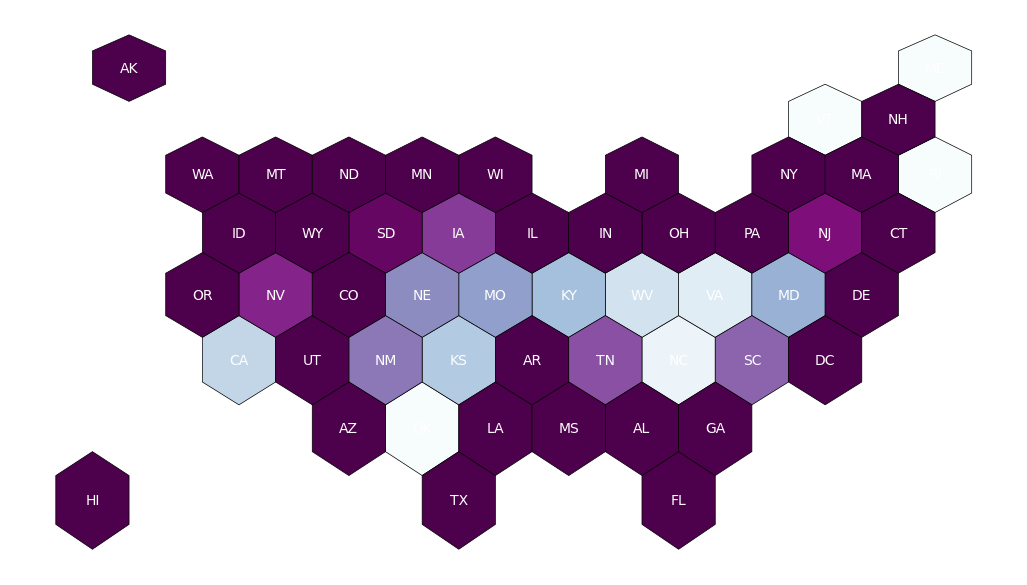

In [18]:
# Initialize the figure
fig, ax = plt.subplots(1, figsize=(13, 13))

# Draw a map with matplotlib
geoData.plot(
    ax=ax, 
    cmap="BuPu", 
    norm=plt.Normalize(vmin=3, vmax=20),
    edgecolor='black', 
    linewidth=.5
)
# add a "centroid" column with the centroid position of each state
geoData['centroid'] = geoData['geometry'].apply(lambda x: x.centroid)

# for each state, annotate with the state name located at the centroid coordinates 
for idx, row in geoData.iterrows():
    ax.annotate(
        text=row['iso3166_2'], 
        xy=row['centroid'].coords[0], 
        horizontalalignment='center', 
        va='center',
        color="white"
    )
# Remove axis
ax.axis('off')



In [12]:
math_max =state_math_avg['math_conf_lvl'].max()
state_math_avg[state_math_avg['math_conf_lvl']== math_max]




,state,math_conf_lvl
21,Massachusetts,5.592133


In [13]:
math_min =state_math_avg['math_conf_lvl'].min()
state_math_avg[state_math_avg['math_conf_lvl']== math_min]

,state,math_conf_lvl
2,Arizona,5.199588


<Axes: xlabel='state'>

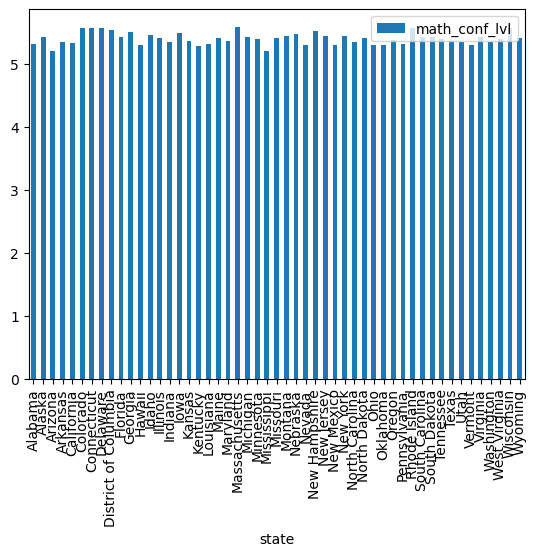

In [14]:
state_math_avg.plot.bar(x='state', y = 'math_conf_lvl')